In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize

from pqcd.utils import rcparams, nsat
plt.rcParams.update(rcparams)

In [2]:
rng = np.random.default_rng()

In [3]:
def sigmoid(x, x0, k):
    """
    Compute the sigmoid function with adjustable parameters for transition 
    location and steepness.

    Parameters
    ----------
    x : float or array-like
        The input value(s) to the sigmoid function.

    x0 : float
        The x-value of the sigmoid's midpoint (transition location).

    k : float
        The steepness of the sigmoid curve. Higher values make the transition steeper.

    Returns
    -------
    float or numpy.ndarray
        The computed sigmoid value(s).
    """
    return 1 / (1 + np.exp(-k*(x-x0)))

In [4]:
def mu_from_cs2(n, J, mu0, n0):
    """
    Given the indefinite integral of (cs2_min/max)/n (J), return the curve 
    mu(n) which passes through (mu0,n0).
    """
    return mu0*np.exp(J - J[np.argmin(np.abs(n-n0))])

In [5]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

In [6]:
# Choose low and high values for the EOS. These could come from a distribution.
muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

X = 1
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

In [7]:
# Construct a array of mu values we will evaluate the EOS at. These can be 
# spaced in anyway you like.
# mu_array = np.concatenate(([muL], muL + np.logspace(-5, np.log(muH-muL), 500, base=np.e)))
mu_array = np.linspace(muL, muH, 1000)

In [8]:
# We define our min and max speed of sounds as a function of density. Here we
# use a sigmoid to transition between some cs2_L_min/max and cs2_H_min/max 
# values.
cs2_L_min = 0
cs2_L_max = 1

cs2_H_min = 1/3 - 0.1
cs2_H_max = 1/3 + 0.1

cs2_n_array = np.linspace(nL, nH, 10000)
# cs2_n_array = np.concatenate(([nL], nL + np.logspace(-5, np.log(nH-nL), 1000, base=np.e)))

# Transition density to go from cs2_min to cs2_max
nT = 30*nsat

# Steepness of the transition
k = 5

cs2_min = cs2_L_min + sigmoid(cs2_n_array, nT, k)*(cs2_H_min - cs2_L_min)
cs2_max = cs2_H_max + (1-sigmoid(cs2_n_array, nT, k))*(cs2_L_max - cs2_H_max)

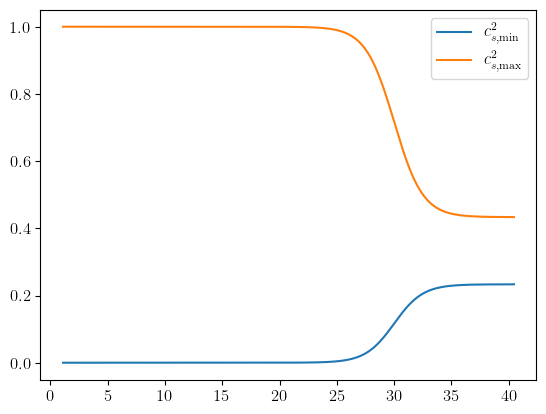

In [9]:
fig, ax = plt.subplots()

ax.plot(cs2_n_array/nsat, cs2_min, label='$c_{s,\mathrm{min}}^2$')
ax.plot(cs2_n_array/nsat, cs2_max, label='$c_{s,\mathrm{max}}^2$')

ax.legend();

In [10]:
# To map these curves to the mu-n plane we need to perform an integral
J_min = cumulative_trapezoid(cs2_min/cs2_n_array, cs2_n_array, initial=0)
J_max = cumulative_trapezoid(cs2_max/cs2_n_array, cs2_n_array, initial=0)

In [11]:
# And we can pre-compute the lines passing through the muH, nH point that
# have the minimum and maximum speed of sound
muH_min = mu_from_cs2(cs2_n_array, J_min, muH, nH)
muH_max = mu_from_cs2(cs2_n_array, J_max, muH, nH)

# We won't need these in general but they are useful for tests...
muL_min = mu_from_cs2(cs2_n_array, J_min, muL, nL)
muL_max = mu_from_cs2(cs2_n_array, J_max, muL, nL)

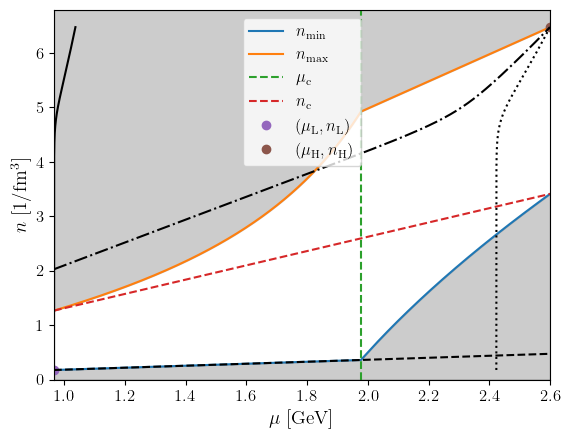

In [12]:
# Quick check things look right...

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(np.linspace(muL, muH, 1000))

ax.plot(muL_min, cs2_n_array, c='k', ls='-')
ax.plot(muL_max, cs2_n_array, c='k', ls='--')

ax.plot(muH_min, cs2_n_array, c='k', ls=':')
_ = ax.plot(muH_max, cs2_n_array, c='k', ls='-.')

In [13]:
# Using the lines plotted above (and the mu_from_cs2 function) we can find EOSs 
# that pass through an arbitrary (mu0,n0) whilst minimising and maximising the 
# change in pressure. 

# The integral constraints (i.e., nmin(mu) and nmax(mu)) are the set of 
# (mu0,n0) points for which the max/min change in pressure is equal to 
# Deltap = pH - pL. This is not so easy to do analytically now...

# For fixed mu0, we have to do some numerical optimisation to find the
# corresponding n0 for which the min/max pressure chnage is equal to Deltap.

In [14]:
def min_p_path(n0, mu0, n, J_min, J_max, muH_min, muL_max, Deltap):
    """
    This function finds the EOS that accumulates the minimum change in pressure
    whilst passing through the (mu0,n0) point. 
    
    The array n goes from nL to nH.
    
    muL_max originates at muL and follows the maximum speed of sound. 

    muH_min originates at muH and follows the minimum speed of sound.

    The arrays J_min and J_max are the indefinite integrals of (cs2_min/max)/n,
    of length n.

    Deltap is the required change in pressure from L to H. 

    The absolute difference between the pressure change of the EOS passing
    through (mu0,n0) and Deltap is returned, such that this function can be 
    used in minimisation routines to find the correct n0.
    """
    # The line passing through the (mu0,n0) point with the maximum speed of sound
    mu0_max = mu_from_cs2(n, J_max, mu0, n0)

    # The line passing through the (mu0,n0) point with the minimum speed of sound
    mu0_min = mu_from_cs2(n, J_min, mu0, n0)

    # Concatenate the above lines. The EOS with minimum pressure change will
    # have the maximum speed of sound after mu0 and the minimum speed of sound
    # before mu0.
    mu0_min_p = np.concatenate((mu0_min[mu0_min < mu0], mu0_max[mu0_max > mu0]))
    n0_min_p = np.concatenate((n[mu0_min < mu0], n[mu0_max > mu0]))

    # The above lines will cross the mu_max_L line...
    min_p_cross_index_1 = np.argmin(np.abs(
        mu0_min - muL_max
    ))

    # ... and the mu_min_H line
    min_p_cross_index_2 = np.argmin(np.abs(
        mu0_max - muH_min
    ))

    # Mask to take the correct region of the EOS passing through (mu0,n0)
    mask = (n0_min_p > n[min_p_cross_index_1]) & (mu0_min_p < mu0_max[min_p_cross_index_2])

    # Concatenate the three regions
    mu_min_p = np.concatenate((
        muL_max[:min_p_cross_index_1],
        mu0_min_p[mask],
        muH_min[min_p_cross_index_2:]
    ))

    n_min_p = np.concatenate((
        n[:min_p_cross_index_1],
        n0_min_p[mask],
        n[min_p_cross_index_2:]
    ))

    # Compute the pressure integral over this EOS
    Deltap_min = pqcd.pressure_integral(
        mu_min_p, n_min_p, 0
    )[-1]

    # We're interested in when this pressure integral is equal to the required 
    # change in pressure
    return abs(Deltap_min - Deltap)

In [15]:
def max_p_path(n0, mu0, n, J_min, J_max, muL_min, muH_max, Deltap):
    """
    Same as min_p_path, but for the path with maximum pressure change.
    """
    # The line passing through the (mu0,n0) point with the maximum speed of sound
    mu0_max = mu_from_cs2(n, J_max, mu0, n0)

    # The line passing through the (mu0,n0) point with the minimum speed of sound
    mu0_min = mu_from_cs2(n, J_min, mu0, n0)

    # Concatenate the above lines. The EOS with maximum pressure change will
    # have the maximum speed of sound before mu0 and the minimum speed of sound
    # after mu0.
    mu0_max_p = np.concatenate((mu0_max[mu0_max < mu0], mu0_min[mu0_min > mu0]))
    n0_max_p = np.concatenate((n[mu0_max < mu0], n[mu0_min > mu0]))

    # Crossing indices
    max_p_cross_index_1 = np.argmin(np.abs(
        mu0_max - muL_min
    ))

    max_p_cross_index_2 = np.argmin(np.abs(
        mu0_min - muH_max
    ))

    # Mask to take the correct region of the EOS passing through (mu0,n0)
    mask = (mu0_max_p > mu0_max[max_p_cross_index_1]) & (n0_max_p < n[max_p_cross_index_2])

    mu_max_p = np.concatenate((
        muL_min[:max_p_cross_index_1],
        mu0_max_p[mask],
        muH_max[max_p_cross_index_2:]
    ))

    n_max_p = np.concatenate((
        n[:max_p_cross_index_1],
        n0_max_p[mask],
        n[max_p_cross_index_2:]
    ))

    # Compute pressure integral and calculate absolute difference
    Deltap_max = pqcd.pressure_integral(
        mu_max_p, n_max_p, 0
    )[-1]

    return abs(Deltap_max - Deltap)

In [16]:
# Check the above functions are working...

mu_max_integral = []
nmax_integral = []

mu_min_integral = []
nmin_integral = []

nmax_guess = nL
nmin_guess = nL

for mu0 in mu_array:

    # Bounds on n based on the speed of sound curves

    n_lower = max((
        cs2_n_array[np.argmin(abs(muL_max-mu0))],
        cs2_n_array[np.argmin(abs(muH_min-mu0))]
    ))

    n_upper = min((
        cs2_n_array[np.argmin(abs(muL_min-mu0))],
        cs2_n_array[np.argmin(abs(muH_max-mu0))]
    ))

    # nmax is given by the path with minimum pressure...

    if nmax_guess < n_lower:
        nmax_guess = n_lower
    elif nmax_guess > n_upper:
        nmax_guess = n_upper

    nmax_opt = minimize(
        min_p_path, 
        nmax_guess, 
        args=(mu0, cs2_n_array, J_min, J_max, muH_min, muL_max, pH - pL),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )

    if nmax_opt.success:
        nmax_integral.append(nmax_opt.x[0])
        mu_max_integral.append(mu0)
        nmax_guess = nmax_opt.x[0]

    if nmin_guess < n_lower:
        nmin_guess = n_lower
    elif nmin_guess > n_upper:
        nmin_guess = n_upper

    nmin_opt = minimize(
        max_p_path, 
        nmin_guess, 
        args=(mu0, cs2_n_array, J_min, J_max, muL_min, muH_max, pH - pL),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )
    
    if nmin_opt.success:
        nmin_integral.append(nmin_opt.x[0])
        mu_min_integral.append(mu0)
        nmin_guess = nmin_opt.x[0]

nmax_integral = np.array(nmax_integral)
nmin_integral = np.array(nmin_integral)

In [62]:
mu0, n0 = 1.75, 2.7

# The line passing through the (mu0,n0) point with the maximum speed of sound
mu0_max = mu_from_cs2(cs2_n_array, J_max, mu0, n0)

# The line passing through the (mu0,n0) point with the minimum speed of sound
mu0_min = mu_from_cs2(cs2_n_array, J_min, mu0, n0)

# Concatenate the above lines. The EOS with minimum pressure change will
# have the maximum speed of sound after mu0 and the minimum speed of sound
# before mu0.
mu0_min_p = np.concatenate((mu0_min[mu0_min < mu0], mu0_max[mu0_max > mu0]))
n0_min_p = np.concatenate((cs2_n_array[mu0_min < mu0], cs2_n_array[mu0_max > mu0]))

# The above lines will cross the mu_max_L line...
min_p_cross_index_1 = np.argmin(np.abs(
    mu0_min - muL_max
))

# ... and the mu_min_H line
min_p_cross_index_2 = np.argmin(np.abs(
    mu0_max - muH_min
))

# Mask to take the correct region of the EOS passing through (mu0,n0)
mask = (n0_min_p > cs2_n_array[min_p_cross_index_1]) & (mu0_min_p < mu0_max[min_p_cross_index_2])

mu_min_p_0 = muL_max[:min_p_cross_index_1]
mu_min_p_1 = mu0_min_p[mask][n0_min_p[mask] < n0]
mu_min_p_2 = mu0_min_p[mask][n0_min_p[mask] > n0]
mu_min_p_3 = muH_min[min_p_cross_index_2:]

# Concatenate the three regions
mu_min_p = np.concatenate((
    muL_max[:min_p_cross_index_1],
    mu0_min_p[mask],
    muH_min[min_p_cross_index_2:]
))

n_min_p_0 = cs2_n_array[:min_p_cross_index_1]
n_min_p_1 = n0_min_p[mask][n0_min_p[mask] < n0]
n_min_p_2 = n0_min_p[mask][n0_min_p[mask] > n0]
n_min_p_3 = cs2_n_array[min_p_cross_index_2:]

n_min_p = np.concatenate((
    cs2_n_array[:min_p_cross_index_1],
    n0_min_p[mask],
    cs2_n_array[min_p_cross_index_2:]
))

# The line passing through the (mu0,n0) point with the maximum speed of sound
mu0_max = mu_from_cs2(cs2_n_array, J_max, mu0, n0)

# The line passing through the (mu0,n0) point with the minimum speed of sound
mu0_min = mu_from_cs2(cs2_n_array, J_min, mu0, n0)

# Concatenate the above lines. The EOS with maximum pressure change will
# have the maximum speed of sound before mu0 and the minimum speed of sound
# after mu0.
mu0_max_p = np.concatenate((mu0_max[mu0_max < mu0], mu0_min[mu0_min > mu0]))
n0_max_p = np.concatenate((cs2_n_array[mu0_max < mu0], cs2_n_array[mu0_min > mu0]))

# Crossing indices
max_p_cross_index_1 = np.argmin(np.abs(
    mu0_max - muL_min
))

max_p_cross_index_2 = np.argmin(np.abs(
    mu0_min - muH_max
))

# Mask to take the correct region of the EOS passing through (mu0,n0)
mask = (mu0_max_p > mu0_max[max_p_cross_index_1]) & (n0_max_p < cs2_n_array[max_p_cross_index_2])

mu_max_p_0 = muL_min[:max_p_cross_index_1]
mu_max_p_1 = mu0_max_p[mask][n0_max_p[mask] < n0]
mu_max_p_2 = mu0_max_p[mask][n0_max_p[mask] > n0]
mu_max_p_3 = muH_max[max_p_cross_index_2:]

mu_max_p = np.concatenate((
    muL_min[:max_p_cross_index_1],
    mu0_max_p[mask],
    muH_max[max_p_cross_index_2:]
))

n_max_p_0 = cs2_n_array[:max_p_cross_index_1]
n_max_p_1 = n0_max_p[mask][n0_max_p[mask] < n0]
n_max_p_2 = n0_max_p[mask][n0_max_p[mask] > n0]
n_max_p_3 = cs2_n_array[max_p_cross_index_2:]

n_max_p = np.concatenate((
    cs2_n_array[:max_p_cross_index_1],
    n0_max_p[mask],
    cs2_n_array[max_p_cross_index_2:]
))

In [63]:
from cmcrameri import cm

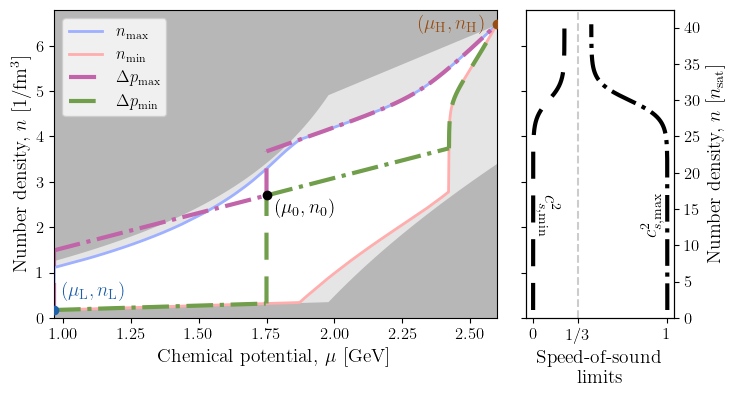

In [64]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,4), width_ratios=(3,1))
fig.subplots_adjust(wspace=0.1)

axs[0].plot(
    muL, 
    nL, 
    'o', 
    c=cm.roma(0.9), 
    zorder=10
    )
axs[0].plot(
    muH, 
    nH, 
    'o', 
    c=cm.roma(0.1), 
    zorder=10
    )

ylim = [0, axs[0].get_ylim()[1]]

axs[0].text(muL+0.03, nL+0.3, r'$(\mu_\mathrm{L}, n_\mathrm{L})$', c=cm.roma(0.9))
axs[0].text(muH-0.04, nH, r'$(\mu_\mathrm{H}, n_\mathrm{H})$', va='center', ha='right', c=cm.roma(0.1))

axs[0].fill_between(
    mu_array, 
    constraints.nmax(mu_array), 
    ylim[1], 
    color='k', 
    alpha=0.2,
    linewidth=0
    )

axs[0].fill_between(
    mu_array, 
    constraints.nmin(mu_array), 
    ylim[0], 
    color='k', 
    alpha=0.2,
    linewidth=0
    )

axs[0].fill_between(
    mu_max_integral, 
    nmax_integral, 
    ylim[1], 
    color='k', 
    alpha=0.1,
    linewidth=0
    )

axs[0].fill_between(
    mu_min_integral, 
    nmin_integral, 
    ylim[0], 
    color='k', 
    alpha=0.1,
    linewidth=0
    )

# axs[0].plot(
#     muL_max, 
#     cs2_n_array/nsat,
#     c='k',
# )

# axs[0].plot(
#     muH_max,
#     cs2_n_array/nsat,
#     c='k',
# )

# axs[0].plot(
#     muL_min,
#     cs2_n_array/nsat,
#     c='k'
# )

# axs[0].plot(
#     muH_min,
#     cs2_n_array/nsat,
#     c='k',
# )

axs[0].plot(mu_max_integral, nmax_integral, label='$n_\mathrm{max}$', c=cm.berlin(0.), lw=2)
axs[0].plot(mu_min_integral, nmin_integral, label='$n_\mathrm{min}$', c=cm.berlin(1.), lw=2)

axs[0].plot(mu0, n0, 'o', zorder=10, c='k')
# axs[0].plot(mu_min_p, n_min_p/nsat, ls='--', dashes=(4, 5))
# axs[0].plot(mu_max_p, n_max_p/nsat, ls='--', dashes=(4, 5))

axs[0].text(mu0+0.03, n0-0.4, r'$(\mu_0, n_0)$')

csl_ls = '--'
csh_ls = '-.'
lw = 3

cmin = cm.bam(0.8)
cmax = cm.bam(0.2)

axs[0].plot(mu_max_p_0, n_max_p_0, ls=csl_ls, c=cmax, lw=lw, dashes=(6.5, 4), label='$\Delta p_\mathrm{max}$')
axs[0].plot(mu_max_p_1, n_max_p_1, ls=csh_ls, c=cmax, lw=lw)
axs[0].plot(mu_max_p_2, n_max_p_2, ls=csl_ls, c=cmax, lw=lw, dashes=(6.5, 4))
axs[0].plot(mu_max_p_3, n_max_p_3, ls=csh_ls, c=cmax, lw=lw)

axs[0].plot(mu_min_p_0, n_min_p_0, ls=csh_ls, c=cmin, lw=lw, label='$\Delta p_\mathrm{min}$')
axs[0].plot(mu_min_p_1, n_min_p_1, ls=csl_ls, c=cmin, lw=lw, dashes=(6.5, 4))
axs[0].plot(mu_min_p_2, n_min_p_2, ls=csh_ls, c=cmin, lw=lw)
axs[0].plot(mu_min_p_3, n_min_p_3, ls=csl_ls, c=cmin, lw=lw, dashes=(6.5, 4))

axs[0].set_xlim(muL, muH)
axs[0].set_ylim(ylim)

axs[1].plot(
    cs2_min, 
    cs2_n_array, 
    c='k', 
    ls=csl_ls, 
    dashes=(6.5, 4),
    label='$c_{s,\mathrm{min}}^2$',
    lw=lw
    )

axs[1].plot(
    cs2_max, 
    cs2_n_array,
    c='k', 
    ls=csh_ls, 
    label='$c_{s,\mathrm{max}}^2$',
    lw=lw
    )

axs[1].text(0.025, 2.25, r'$c_{s,\mathrm{min}}^2$', rotation=-90, ha='left', va='center')
axs[1].text(1-0.025, 2.25, r'$c_{s,\mathrm{max}}^2$', rotation=90, ha='right', va='center')

axs[1].axvline(1/3, c='k', linestyle='--', alpha=0.2)

axs[1].set_xticks([0, 1/3, 1])
axs[1].set_xticklabels([0, '$1/3$', 1])

twinx = axs[1].twinx()
twinx.set_ylim(np.array(axs[0].get_ylim())/nsat)
twinx.set_ylabel(r'Number density, $n\ [n_\mathrm{sat}]$')

axs[0].legend(loc='upper left')

axs[0].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
axs[0].set_ylabel(r'Number density, $n$ [1/fm$^3$]')

# axs[1].set_xlabel('$c_s^2$')
axs[1].set_xlabel('Speed-of-sound\nlimits');

fig.savefig('general_cs2_limits.pdf', bbox_inches='tight')

In [19]:
# bug?
nmin_integral

[0.176,
 0.176,
 0.17662974347617608,
 0.17662974347617608,
 0.1772594869523522,
 0.1772594869523522,
 0.17788923042852828,
 0.17788923042852828,
 0.1785189739047044,
 0.1785189739047044,
 0.17914871738088048,
 0.17914871738088048,
 0.17977846085705657,
 0.17977846085705657,
 0.18040820433323268,
 0.18040820433323268,
 0.18103794780940877,
 0.18103794780940877,
 0.18166769128558485,
 0.18166769128558485,
 0.18166769128558485,
 0.18229743476176097,
 0.18229743476176097,
 0.18292717823793705,
 0.18292717823793705,
 0.18355692171411317,
 0.18355692171411317,
 0.18418666519028926,
 0.18418666519028926,
 0.18481640866646534,
 0.18481640866646534,
 0.18544615214264146,
 0.18544615214264146,
 0.18607589561881754,
 0.18607589561881754,
 0.18670563909499366,
 0.18670563909499366,
 0.18733538257116975,
 0.18733538257116975,
 0.18733538257116975,
 0.18796512604734583,
 0.18796512604734583,
 0.18859486952352195,
 0.18859486952352195,
 0.18922461299969803,
 0.18922461299969803,
 0.18985435647587412

In [17]:
# To make our proposal we only need the integral constraints at the next value
# of mu (not the full curve as above). 

# To make proposals based on the pQCD tension index, I, we need to be able to
# calculate it...

In [16]:
def pQCD_tension_index(muL, nL, pL, muH, nH, pH, n, J_min, J_max):
    
    # The EOS with the minimum pressure is given by the following two lines
    muL_max = mu_from_cs2(n, J_max, muL, nL)
    muH_min = mu_from_cs2(n, J_min, muH, nH)

    # Concatenate
    cross_index = np.argmin(np.abs(muL_max - muH_min))
    mu_minp = np.concatenate((muL_max[:cross_index], muH_min[cross_index:]))

    # Calculate the minimum pressure
    Deltap_min = pqcd.pressure_integral(mu_minp, n, 0)[-1]

    # The EOS with the maximum pressure is given by the following two lines
    muL_min = mu_from_cs2(n, J_min, muL, nL)
    muH_max = mu_from_cs2(n, J_max, muH, nH)

    # Concatenate
    cross_index = np.argmin(np.abs(muL_min - muH_max))
    mu_maxp = np.concatenate((muL_min[:cross_index], muH_max[cross_index:]))

    # Calculate the maximum pressure
    Deltap_max = pqcd.pressure_integral(mu_maxp, n, 0)[-1]

    # Calculate the tension index
    Deltap = pH - pL

    return (Deltap - Deltap_min)/(Deltap_max - Deltap_min)

In [17]:
# Lets consider the first step in the random walk

current_mu = muL
current_n = nL
current_p = pL

# At each step we effectively treat the current point as the new L values. This
# means we should mask the cs2_n_array to only have values of n greater than
# the current n. The same is true for the J_min and J_max arrays.

mask = cs2_n_array >= current_n

cs2_n_array_masked = cs2_n_array[mask]
J_min_masked = J_min[mask]
J_max_masked = J_max[mask]

# We don't need to re-compute the muH_min/max lines as they are fixed, but 
# they need to be masked
muH_min_masked = muH_min[mask]
muH_max_masked = muH_max[mask]

current_I = pQCD_tension_index(
    muL = current_mu,
    nL = current_n,
    pL = current_p,
    muH = muH,
    nH = nH,
    pH = pH,
    n = cs2_n_array_masked,
    J_min = J_min_masked,
    J_max = J_max_masked
)

# We will also need new muL_min/max curves

# The line originating from (current_mu,current_n) that has the maximum speed 
# of sound
mu_current_max = mu_from_cs2(cs2_n_array_masked, J_max_masked, current_mu, current_n)

# The line originating from (current_mu,current_n) that has the minimum speed
# of sound
mu_current_min = mu_from_cs2(cs2_n_array_masked, J_min_masked, current_mu, current_n)

next_mu = mu_array[1]

# Bounds on n based on the speed of sound curves. These are based on the L
# values, but at each step we could use the current values to get better bounds.
n_lower = max((
    cs2_n_array[np.argmin(abs(muL_max-next_mu))],
    cs2_n_array[np.argmin(abs(muH_min-next_mu))]
))

n_upper = min((
    cs2_n_array[np.argmin(abs(muL_min-next_mu))],
    cs2_n_array[np.argmin(abs(muH_max-next_mu))]
))

# Get the bounds on n based on the integral constraints

nmax_guess = current_n
nmin_guess = current_n

nmax_opt = minimize(
    min_p_path, 
    nmax_guess, 
    args=(
        next_mu, 
        cs2_n_array_masked, 
        J_min_masked, 
        J_max_masked, 
        muH_min_masked, 
        mu_current_max, 
        pH - current_p
        ),
    method='Nelder-Mead',
    bounds=[(n_lower, n_upper)]
    )

if nmax_opt.success:
    next_n_upper = nmax_opt.x[0]

nmin_opt = minimize(
    max_p_path, 
    nmin_guess, 
    args=(
        next_mu, 
        cs2_n_array_masked, 
        J_min_masked, 
        J_max_masked, 
        mu_current_min, 
        muH_max_masked, 
        pH - current_p
        ),
    method='Nelder-Mead',
    bounds=[(n_lower, n_upper)]
    )

if nmin_opt.success:
    next_n_lower = nmin_opt.x[0]

In [ ]:
fig, ax = plt.subplots()

ax.plot(current_mu, current_n, 'o', c='C4')
ax.axvline(next_mu, c='C4')

xlim = ax.get_xlim()

ax.plot(mu_current_min, cs2_n_array_masked, c='k', ls='-')
ax.plot(mu_current_max, cs2_n_array_masked, c='k', ls='--')

ax.axhline(n_lower, c='k', ls=':')
ax.axhline(n_upper, c='k', ls=':')

ax.plot(next_mu, next_n_lower, 'o', c='k')
ax.plot(next_mu, next_n_upper, 'o', c='k')

_ = ax.set_xlim(xlim)

In [19]:
# We can then convert these upper and lower bounds to upper and lower bounds on
# the tension index.

next_p_lower = current_p + 0.5*(current_n + next_n_lower)*(next_mu - current_mu)
next_p_upper = current_p + 0.5*(current_n + next_n_upper)*(next_mu - current_mu)

mask_lower = cs2_n_array >= next_n_lower
mask_upper = cs2_n_array >= next_n_upper

next_I_lower = pQCD_tension_index(
    muL = next_mu,
    nL = next_n_upper,
    pL = next_p_upper,
    muH = muH,
    nH = nH,
    pH = pH,
    n = cs2_n_array[mask_upper],
    J_min = J_min[mask_upper],
    J_max = J_max[mask_upper]
)

next_I_upper = pQCD_tension_index(
    muL = next_mu,
    nL = next_n_lower,
    pL = next_p_lower,
    muH = muH,
    nH = nH,
    pH = pH,
    n = cs2_n_array[mask_lower],
    J_min = J_min[mask_lower],
    J_max = J_max[mask_lower]
)

next_I_lower = max(0, next_I_lower)
next_I_upper = min(1, next_I_upper)

In [ ]:
next_I_lower, next_I_upper

In [21]:
next_I = current_I + rng.normal(loc=0., scale=0.1)

if next_I < next_I_lower:
    next_I = next_I_lower
elif next_I > next_I_upper:
    next_I = next_I_upper

In [ ]:
next_I

In [23]:
# Given a value of I, we now need to invert this to get next_n. 

def n_opt(nproposed, next_mu, next_I, current_mu, current_n, current_p, cs2_n_array, J_min, J_max, pH):
    """
    Given a proposed value of n, calculate the tension index and return the 
    absolute difference between this and the target value.
    """
    I = pQCD_tension_index(
        muL = next_mu,
        nL = nproposed,
        pL = current_p + 0.5*(current_n + nproposed)*(next_mu - current_mu),
        muH = muH,
        nH = nH,
        pH = pH,
        n = cs2_n_array[cs2_n_array >= nproposed],
        J_min = J_min[cs2_n_array >= nproposed],
        J_max = J_max[cs2_n_array >= nproposed]
    )

    return abs(I - next_I)

In [24]:
nproposed_array = np.linspace(next_n_lower, next_n_upper, 1000)

n_opt_array = np.array([
    n_opt(
        nproposed, 
        next_mu, 
        next_I, 
        current_mu, 
        current_n, 
        current_p, 
        cs2_n_array, 
        J_min, 
        J_max, 
        pH
        ) 
        for nproposed in nproposed_array
        ])

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(nproposed_array, n_opt_array)

In [ ]:
# Apply the minimisation routine to find the best value of n

n_opt_min = minimize(
    n_opt,
    current_n,
    args=(
        next_mu, 
        next_I, 
        current_mu, 
        current_n, 
        current_p, 
        cs2_n_array, 
        J_min, 
        J_max, 
        pH
        ),
    method='Nelder-Mead',
    bounds=[(next_n_lower, next_n_upper)]
    )

next_n = n_opt_min.x[0]
next_n

In [ ]:
# Lets try to iterate through mu_array...

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(mu_min_integral, nmin_integral, label='$n_\mathrm{min}$')
ax.plot(mu_max_integral, nmax_integral, label='$n_\mathrm{max}$')

current_n = nL
current_p = pL
current_I = pQCD_tension_index(
    muL = muL,
    nL = nL,
    pL = pL,
    muH = muH,
    nH = nH,
    pH = pH,
    n = cs2_n_array,
    J_min = J_min,
    J_max = J_max
)

n_array = [current_n]
p_array = [current_p]
I_array = [current_I]

# There are situations where the EOS behaviour becomes determined. We can 
# break the loop over mu values when this happens.
determined = False

for i in range(len(mu_array)-1):

    current_mu = mu_array[i]
    next_mu = mu_array[i+1]

    mask = cs2_n_array >= current_n

    cs2_n_array_masked = cs2_n_array[mask]
    J_min_masked = J_min[mask]
    J_max_masked = J_max[mask]

    muH_min_masked = muH_min[mask]
    muH_max_masked = muH_max[mask]

    mu_current_max = mu_from_cs2(cs2_n_array_masked, J_max_masked, current_mu, current_n)
    mu_current_min = mu_from_cs2(cs2_n_array_masked, J_min_masked, current_mu, current_n)

    n_lower = max((
        cs2_n_array[np.argmin(abs(muL_max-next_mu))],
        cs2_n_array[np.argmin(abs(muH_min-next_mu))]
    ))

    n_upper = min((
        cs2_n_array[np.argmin(abs(muL_min-next_mu))],
        cs2_n_array[np.argmin(abs(muH_max-next_mu))]
    ))

    nmax_guess = current_n
    nmin_guess = current_n

    nmax_opt = minimize(
        min_p_path, 
        nmax_guess, 
        args=(
            next_mu, 
            cs2_n_array_masked, 
            J_min_masked, 
            J_max_masked, 
            muH_min_masked, 
            mu_current_max, 
            pH - current_p
            ),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )

    if nmax_opt.success:
        next_n_upper = nmax_opt.x[0]

    nmin_opt = minimize(
        max_p_path, 
        nmin_guess, 
        args=(
            next_mu, 
            cs2_n_array_masked, 
            J_min_masked, 
            J_max_masked, 
            mu_current_min, 
            muH_max_masked, 
            pH - current_p
            ),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )

    if nmin_opt.success:
        next_n_lower = nmin_opt.x[0]

    if next_n_lower > next_n_upper:
        print('next_n_lower > next_n_upper')
        break

    next_p_lower = current_p + 0.5*(current_n + next_n_lower)*(next_mu - current_mu)
    next_p_upper = current_p + 0.5*(current_n + next_n_upper)*(next_mu - current_mu)

    mask_lower = cs2_n_array >= next_n_lower
    mask_upper = cs2_n_array >= next_n_upper

    next_I_lower = pQCD_tension_index(
        muL = next_mu,
        nL = next_n_upper,
        pL = next_p_upper,
        muH = muH,
        nH = nH,
        pH = pH,
        n = cs2_n_array[mask_upper],
        J_min = J_min[mask_upper],
        J_max = J_max[mask_upper]
    )

    next_I_upper = pQCD_tension_index(
        muL = next_mu,
        nL = next_n_lower,
        pL = next_p_lower,
        muH = muH,
        nH = nH,
        pH = pH,
        n = cs2_n_array[mask_lower],
        J_min = J_min[mask_lower],
        J_max = J_max[mask_lower]
    )

    next_I_lower = max(0, next_I_lower)
    next_I_upper = min(1, next_I_upper)

    next_I = current_I + rng.normal(loc=0., scale=0.1)

    if next_I < next_I_lower:
        next_I = next_I_lower
    elif next_I > next_I_upper:
        next_I = next_I_upper

    n_opt_min = minimize(
        n_opt,
        current_n,
        args=(
            next_mu, 
            next_I, 
            current_mu, 
            current_n, 
            current_p, 
            cs2_n_array, 
            J_min, 
            J_max, 
            pH
            ),
        method='Nelder-Mead',
        bounds=[(next_n_lower, next_n_upper)]
        )

    next_n = n_opt_min.x[0]
    next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)

    n_array.append(next_n)
    p_array.append(next_p)
    I_array.append(next_I)

    current_n = next_n
    current_p = next_p
    # current_I = next_I

_ = ax.plot(mu_array[:len(n_array)], n_array, c='k')

In [ ]:
current_I, current_mu, current_n, current_p

In [31]:
beta = current_n/current_mu**3

In [ ]:
(beta/4)*(muH**4 - current_mu**4)

In [ ]:
pH - current_p

In [70]:
# Repeat...

In [36]:
scale = np.diff(mu_array)/max(np.diff(mu_array))

In [ ]:
constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(mu_min_integral, nmin_integral, label='$n_\mathrm{min}$')
ax.plot(mu_max_integral, nmax_integral, label='$n_\mathrm{max}$')

repeats = 50

for _ in range(repeats):

    current_n = nL
    current_p = pL
    current_I = pQCD_tension_index(
        muL = muL,
        nL = nL,
        pL = pL,
        muH = muH,
        nH = nH,
        pH = pH,
        n = cs2_n_array,
        J_min = J_min,
        J_max = J_max
    )

    n_array = [current_n]
    p_array = [current_p]
    I_array = [current_I]

    for i in range(len(mu_array)-1):

        current_mu = mu_array[i]
        next_mu = mu_array[i+1]

        mask = cs2_n_array >= current_n

        cs2_n_array_masked = cs2_n_array[mask]
        J_min_masked = J_min[mask]
        J_max_masked = J_max[mask]

        muH_min_masked = muH_min[mask]
        muH_max_masked = muH_max[mask]

        mu_current_max = mu_from_cs2(cs2_n_array_masked, J_max_masked, current_mu, current_n)
        mu_current_min = mu_from_cs2(cs2_n_array_masked, J_min_masked, current_mu, current_n)

        n_lower = max((
            cs2_n_array[np.argmin(abs(muL_max-next_mu))],
            cs2_n_array[np.argmin(abs(muH_min-next_mu))]
        ))

        n_upper = min((
            cs2_n_array[np.argmin(abs(muL_min-next_mu))],
            cs2_n_array[np.argmin(abs(muH_max-next_mu))]
        ))

        nmax_guess = current_n
        nmin_guess = current_n

        nmax_opt = minimize(
            min_p_path, 
            nmax_guess, 
            args=(
                next_mu, 
                cs2_n_array_masked, 
                J_min_masked, 
                J_max_masked, 
                muH_min_masked, 
                mu_current_max, 
                pH - current_p
                ),
            method='Nelder-Mead',
            bounds=[(n_lower, n_upper)]
            )

        if nmax_opt.success:
            next_n_upper = nmax_opt.x[0]

        nmin_opt = minimize(
            max_p_path, 
            nmin_guess, 
            args=(
                next_mu, 
                cs2_n_array_masked, 
                J_min_masked, 
                J_max_masked, 
                mu_current_min, 
                muH_max_masked, 
                pH - current_p
                ),
            method='Nelder-Mead',
            bounds=[(n_lower, n_upper)]
            )

        if nmin_opt.success:
            next_n_lower = nmin_opt.x[0]

        if next_n_lower > next_n_upper:
            print('n_lower > n_upper')
            break

        next_p_lower = current_p + 0.5*(current_n + next_n_lower)*(next_mu - current_mu)
        next_p_upper = current_p + 0.5*(current_n + next_n_upper)*(next_mu - current_mu)

        mask_lower = cs2_n_array >= next_n_lower
        mask_upper = cs2_n_array >= next_n_upper

        next_I_lower = pQCD_tension_index(
            muL = next_mu,
            nL = next_n_upper,
            pL = next_p_upper,
            muH = muH,
            nH = nH,
            pH = pH,
            n = cs2_n_array[mask_upper],
            J_min = J_min[mask_upper],
            J_max = J_max[mask_upper]
        )

        next_I_upper = pQCD_tension_index(
            muL = next_mu,
            nL = next_n_lower,
            pL = next_p_lower,
            muH = muH,
            nH = nH,
            pH = pH,
            n = cs2_n_array[mask_lower],
            J_min = J_min[mask_lower],
            J_max = J_max[mask_lower]
        )

        next_I_lower = max(0, next_I_lower)
        next_I_upper = min(1, next_I_upper)

        x = rng.uniform()
        if x < scale[i]/len(mu_array):
            print('PT')
            I_scale = 0.5
        else:
            I_scale = 0.1
        next_I = 0.5 + rng.normal(loc=0., scale=I_scale)

        if next_I < next_I_lower:
            next_I = next_I_lower
        elif next_I > next_I_upper:
            next_I = next_I_upper

        n_opt_min = minimize(
            n_opt,
            current_n,
            args=(
                next_mu, 
                next_I, 
                current_mu, 
                current_n, 
                current_p, 
                cs2_n_array, 
                J_min, 
                J_max, 
                pH
                ),
            method='Nelder-Mead',
            bounds=[(next_n_lower, next_n_upper)]
            )

        next_n = n_opt_min.x[0]
        next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)

        n_array.append(next_n)
        p_array.append(next_p)
        I_array.append(next_I)

        current_n = next_n
        current_p = next_p
        # current_I = next_I

    _ = ax.plot(mu_array[:len(n_array)], n_array, color='k', alpha=0.1)

In [37]:
jump_locs = []

repeats = 10000
for _ in range(repeats):
    for i, mu in enumerate(mu_array[1:]):
        x = rng.uniform()
        if x < scale[i]/len(mu_array):
            jump_locs.append(mu)

In [ ]:
fig, ax = plt.subplots()
ax.axvline(muL, c='k')
ax.axvline(muH, c='k')
_ = ax.hist(jump_locs, bins=30)

In [29]:
mu_array, n_array, p_array = np.loadtxt('random_walks/01.dat').T

In [46]:
N = len(n_array)

In [ ]:
np.savetxt('random_walks/01.dat', np.vstack((mu_array[:N], n_array, p_array)).T)

In [30]:
epsilon_array = n_array*mu_array - p_array

In [ ]:
len(epsilon_array)

In [ ]:
constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(mu_array[:len(n_array)], n_array, color='k', alpha=0.1);

In [ ]:
np.diff(n_array)

In [ ]:
np.gradient(n_array, mu_array)

In [ ]:
constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_epsilon_p(mu_array)
fig.set_dpi(180)

ax.plot(epsilon_array, p_array, color='k', alpha=0.1);

In [ ]:
cs2_array = np.diff(p_array)/np.diff(epsilon_array)

In [ ]:
cs2_array

In [ ]:
fig, ax = plt.subplots()

ax.plot(n_array[:-1], cs2_array)